<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 435, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 435 (delta 110), reused 82 (delta 80), pack-reused 250
Receiving objects: 100% (435/435), 70.49 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (204/204), done.
Checking out files: 100% (59/59), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=30522 sha256=133034de6bf09ba85764c49c3a6a7d5b261b23865807429a21ed34ec362b4dd6
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [2]:
from dul_2021.utils.hw12_utils import *

In [3]:
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal
import numpy as np
import torch.autograd as autograd

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

# Linear and Independent

## Classes

In [5]:
class Classifier(nn.Module):
  def __init__(self, num_of_classes=10, hidden_dim=400):
    super().__init__()

    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(28 * 28, hidden_dim),
                             nn.ReLU(),
                             nn.Linear(hidden_dim, num_of_classes))

  def forward(self, x):
    return self.lin(x)

In [6]:
class ZNet(nn.Module):
  def __init__(self, latent_dim=16, hidden_dim=400):
    super().__init__()
    
    self.lin = nn.Sequential(nn.Flatten(),
                             nn.Linear(28 * 28, hidden_dim),
                             nn.ReLU(),
                             nn.Linear(hidden_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Linear(hidden_dim, 2 * latent_dim))

  def forward(self, x):
    return self.lin(x)

In [7]:
class UpscaleNet(nn.Module):
  def __init__(self, latent_dim=16, embedding_dim=40, hidden_dim=400):
    super().__init__()
    self.hid_dim = hidden_dim
    self.lin = nn.Sequential(nn.Linear(latent_dim + embedding_dim, hidden_dim), 
                             nn.ReLU(),
                             nn.Linear(hidden_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Linear(hidden_dim, 28 * 28),
                             nn.Tanh())

  def forward(self, x):
    x = (self.lin(x) + 1) * 0.5
    return x.reshape(-1, 1, 28, 28)

In [8]:
class VAE_Linear(nn.Module):
  def __init__(self, latent_dim=16, embedding_dim=40, num_of_classes=10):
    super().__init__()
    self.embd = torch.randn((num_of_classes, embedding_dim), device=device)
    self.l_dim = latent_dim

    self.π = Classifier(num_of_classes)
    self.downscale = ZNet(latent_dim)
    self.upscale = UpscaleNet(latent_dim, embedding_dim)

    self.support = torch.arange(num_of_classes).expand(500, num_of_classes).to(device)
    self.kl_constant = - np.log(num_of_classes)
    self.cls_num = num_of_classes

    self.sf = nn.Softmax(dim=1)

  def compute_normal_dkl(self, μ, ln_σ):
    """
    Compute KL divergence as sum of D_KL of independent
    """
    mask = torch.sign(ln_σ)

    dkl = - 2 * torch.exp(torch.log(torch.abs(ln_σ)) - ln_σ) * mask
    dkl += torch.exp(2 * ln_σ)
    dkl += μ ** 2
    dkl -= 1

    return 0.5 * dkl.sum(dim=1)

  def get_z_l(self, x, y):
    # Distribution over labels
    π = self.π(x)
    dist_labeled = Categorical(probs=self.sf(π))

    # Log-prob of true label
    logp_y = dist_labeled.log_prob(y)

    # Mean and std
    latent_param = self.downscale(x)
    μ, ln_σ = torch.chunk(latent_param, 2, 1)
    σ = torch.exp(ln_σ)

    # Loss
    normal_dkl = self.compute_normal_dkl(μ, ln_σ)
    loss_labeled = (logp_y - normal_dkl).mean()
    
    # Sample
    z = Normal(μ, σ).rsample()

    return z, loss_labeled

  def get_z_u(self, x):
    # Distribution over labels
    π = self.π(x)
    dist_unlabeled = Categorical(probs=self.sf(π))
    prob_π = dist_unlabeled.probs
    
    # KL divergence of label distribution
    dkl_cat = self.kl_constant + dist_unlabeled.entropy()

    # Mean and std
    latent_param = self.downscale(x)
    μ, ln_σ = torch.chunk(latent_param, 2, 1)
    σ = torch.exp(ln_σ)

    # Loss
    normal_dkl = self.compute_normal_dkl(μ, ln_σ)    
    loss_unlabeled = (dkl_cat - normal_dkl).mean()
    
    # Sample
    z = Normal(μ, σ).rsample()

    return z, loss_unlabeled, prob_π

  def decode(self, z, y):
    """
    Get image from latent `z` and class label `y` 
    """
    w = torch.cat((z, self.embd[y]), dim=1)
    return self.upscale(w)

  def get_decoder_loss_labeled(self, x, x_rec):
    p_total = - ((x - x_rec) ** 2).sum(dim=(1, 2, 3))
    return p_total.mean()

  def get_decoder_loss_unlabeled(self, x, x_rec, prob, class_id):
    p_total = - ((x - x_rec) ** 2).sum(dim=(1, 2, 3))
    return (prob[:, class_id] * p_total).mean()

## Model, hyperparameters

In [21]:
from torch.optim import Adam

model = VAE_Linear().to(device)
opt = Adam(model.parameters(), 1e-4)

n_epochs = 30
batch_size = 64

## Load data

In [10]:
train_data, test_dataset = get_data('MNIST', binary=False)

class SSDataset:
  def __init__(self, data, c=4_000, train=True):
    self.data = data
    self.c = c
    self.train = train

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    x, y = self.data[i]
    x[x >= 0.] = 1.
    x[x < 0.] = 0.
    
    if not self.train:
      return x, y

    y = y if i < self.c else -1 
    return x, y

train_data, test_dataset = SSDataset(train_data), SSDataset(test_dataset, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [11]:
from torch.utils.data import DataLoader, Subset

labeled_idx = list(range(train_data.c))
labeled_subset = Subset(train_data, labeled_idx)

labeled_data = DataLoader(labeled_subset, 
                          batch_size=batch_size,
                          shuffle=True, drop_last=True)

all_data = DataLoader(train_data,
                      batch_size=batch_size,
                      shuffle=True, drop_last=True)

test_data = DataLoader(test_dataset,
                       batch_size=256)

## Train loop

In [12]:
loss_record = []
Accuracy = []
one_s = torch.ones((1000, ), device=device).long()

for epoch in range(n_epochs):
  for (x_l, y), (x_u, _) in zip(labeled_data, all_data):
    x_l = x_l.to(device)
    x_u = x_u.to(device)
    y = y.to(device)

    # Get latent on labeled and unlabeled
    z_l, loss_el = model.get_z_l(x_l, y)
    z_u, loss_eu, prob = model.get_z_u(x_u)

    # Decoder loss on labeled data
    reconstruction_l = model.decode(z_l, y)
    loss_dl = model.get_decoder_loss_labeled(x_l, reconstruction_l)

    # Decoder loss on unlabeled data (expectation over all labels)
    loss_du = 0
    for i in range(10):
      reconstruction_u = model.decode(z_u, one_s[:z_u.shape[0]] * i)
      loss_du += model.get_decoder_loss_unlabeled(x_u, reconstruction_u, prob, i)

    total_loss = - (loss_el + loss_dl + loss_eu + loss_du)
  
    opt.zero_grad()
    total_loss.backward()
    opt.step()

    loss_record.append(total_loss.item())

  # Compute accuracy on test dataset
  acc = 0
  for batch in test_data:
    X = batch[0].to(device)
    label = batch[1].to(device)
    
    with torch.no_grad():
      π = model.π(X)
      out = torch.argmax(π, dim=1)

    acc += (out == label).sum().item()

  Accuracy.append(acc / len(test_dataset))

  print(f"EPOCH : {epoch}")
  print(f"\t loss : {sum(loss_record[-100:]):.4f}")
  print(f"\t Accuracy : {Accuracy[-1]:.4f}")

EPOCH : 0
	 loss : 16237.1160
	 Accuracy : 0.2979
EPOCH : 1
	 loss : 16163.3514
	 Accuracy : 0.6035
EPOCH : 2
	 loss : 13137.1712
	 Accuracy : 0.7085
EPOCH : 3
	 loss : 12394.0441
	 Accuracy : 0.7654
EPOCH : 4
	 loss : 11846.0121
	 Accuracy : 0.7865
EPOCH : 5
	 loss : 11561.4073
	 Accuracy : 0.7970
EPOCH : 6
	 loss : 11333.0947
	 Accuracy : 0.8055
EPOCH : 7
	 loss : 11246.7685
	 Accuracy : 0.8108
EPOCH : 8
	 loss : 11210.1236
	 Accuracy : 0.8133
EPOCH : 9
	 loss : 11141.4457
	 Accuracy : 0.8247
EPOCH : 10
	 loss : 11048.0215
	 Accuracy : 0.8279
EPOCH : 11
	 loss : 10988.8136
	 Accuracy : 0.8371
EPOCH : 12
	 loss : 10894.4820
	 Accuracy : 0.8409
EPOCH : 13
	 loss : 10778.3408
	 Accuracy : 0.8489
EPOCH : 14
	 loss : 10657.8864
	 Accuracy : 0.8590
EPOCH : 15
	 loss : 10538.2313
	 Accuracy : 0.8636
EPOCH : 16
	 loss : 10417.3546
	 Accuracy : 0.8671
EPOCH : 17
	 loss : 10381.5198
	 Accuracy : 0.8732
EPOCH : 18
	 loss : 10281.4264
	 Accuracy : 0.8782
EPOCH : 19
	 loss : 10222.9585
	 Accuracy

## Result

In [14]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    return loss_record, Accuracy

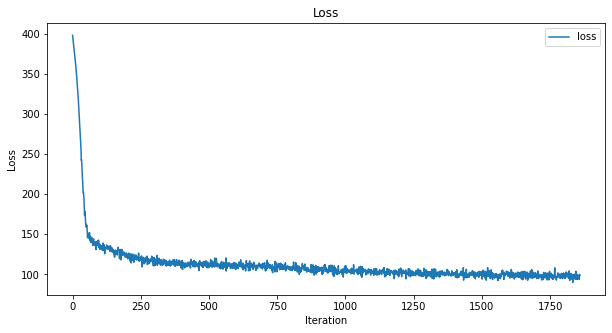

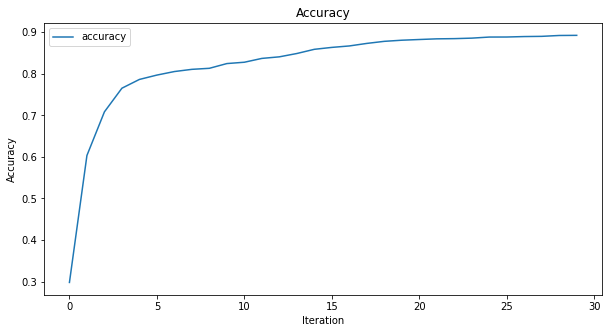

In [18]:
plt.rcParams["figure.figsize"] = [10., 5.]
b_resul(b)

## Conditional generation

In [19]:
z = torch.randn((10, 16), device=device)
Img = np.zeros((10, 10, 28, 28))

with torch.no_grad():
  for i in range(10):
    X = model.decode(z, one_s[:10] * i)

    X = X.permute((0, 2, 3, 1)).squeeze(-1)
    X = X.cpu().numpy()
    Img[i] = X

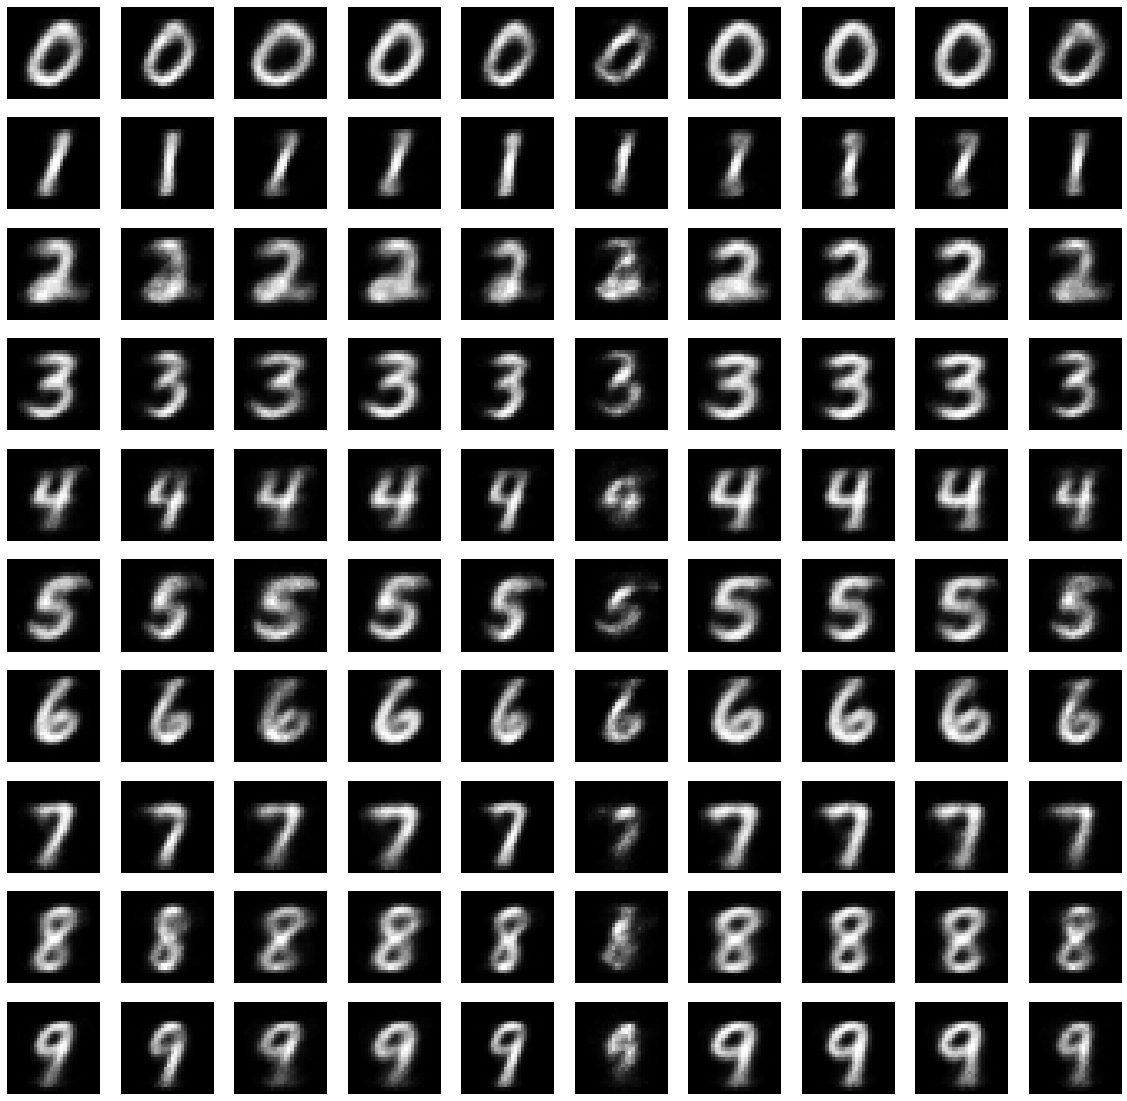

In [20]:
plt.rcParams["figure.figsize"] = [20., 20.]

for i in range(10):
  for j in range(10):
    plt.subplot(10, 10, i * 10 + j + 1)
    plt.imshow(Img[i, j], cmap='gray')
    plt.axis('off')

plt.show()